In [1]:
from PIL import Image
import numpy as np
import os

In [2]:
# Constants
patch_width = 256
limit_of_mask_cloud_allowed = 30

# For 1 single image:

### Read the image

In [3]:
image = Image.open('Images/Image 2013_8.png')
width, height = image.size
width, height

(2760, 1664)

### Calculate wigth and heigth to be multiple of 256

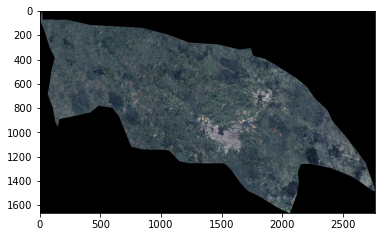

In [4]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.show()

In [5]:
print(f'the original heigth is: {height}')
print(f'the cropped height is: {int(height/patch_width)*patch_width}')

the original heigth is: 1664
the cropped height is: 1536


In [6]:
print(f'the original width is: {width}')
print(f'the cropped width is: {int(width/patch_width)*patch_width}')

the original width is: 2760
the cropped width is: 2560


### Crop width and height 

In [7]:
def crop_image(image):
    
    width, height = image.size
    
    new_width = int(width/patch_width)*patch_width
    new_height = int(height/patch_width)*patch_width
    
    left = int((width - new_width)/2)
    top = int((height - new_height)/2)
    right = round((width + new_width)/2)
    bottom = round((height + new_height)/2)

    image = image.crop((left, top, right, bottom))
    return image


In [8]:
image = crop_image(image)
image.size

(2560, 1536)

### Plot cropped image

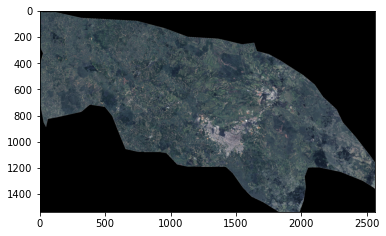

In [9]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.show()

### Generate Patches of 256, 266, 3

In [10]:
from patchify import patchify
def generate_patches(image):
    #This will split the image into small images of shape [256, 256]
    patches = patchify(np.asarray(image), (patch_width, patch_width,3), step=patch_width)
    return patches

In [11]:
patches = generate_patches(image)
patches.shape
# Patches Rows, Patches columns, batch, width, height, 3 (rgb)

(6, 10, 1, 256, 256, 3)

### Plot patches

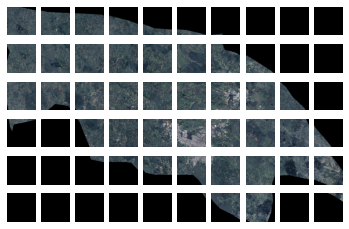

NameError: name 'fig' is not defined

In [12]:
# Grid
f, axarr = plt.subplots(patches.shape[0], patches.shape[1], )#, figsize=(30/axis[1], 10))

for i in range(0,patches.shape[0]):
    for j in range (0,patches.shape[1]):
        # Plot
        axarr[i,j].imshow(patches[i][j][0])
        axarr[i,j].axis('off')
        
plt.show()

fig.savefig('image_as_patch.png')

## Filter mask(black) and clouds(white)

### filter images with black pixels (mask)

In [ ]:
count = np.count_nonzero(patches[0, 5, 0] == 0)
print('Total occurences of "0" in array: ', count)

### filter images with white pixels (clouds)

In [13]:
count = np.count_nonzero(patches[4, 8, 0] == 255)
print('Total occurences of "0" in array: ', count)

Total occurences of "0" in array:  4


In [14]:
def verify_image(image, limit_of_mask_cloud_allowed, verbose = True):
    
    # Calculate pixels
    total_pixels = image.shape[0] * image.shape[1] * image.shape[2]
    # Calculate allowed number of pixels
    allowed_pixels = (total_pixels * limit_of_mask_cloud_allowed) / 100
    
    # Count mask (black)
    count_black = np.count_nonzero(image == 0)
    # Count clouds (white)
    count_white = np.count_nonzero(image == 255)
    
    # Verify if that we have less than limit_of_mask_cloud_allowed (40%) of clouds or mask
    if ((count_black + count_white) < allowed_pixels):
        if verbose:
            print('the patch is allowed')
        return True
    else:
        if verbose:
            print('the patch is not allowed')
        return False


In [15]:
verify_image(patches[4, 8, 0], limit_of_mask_cloud_allowed)

the patch is allowed


True

In [16]:
verify_image(patches[0, 5, 0], limit_of_mask_cloud_allowed)

the patch is not allowed


False

In [17]:
verify_image(patches[4, 6, 0], limit_of_mask_cloud_allowed)

the patch is allowed


True

# Apply all for each image

In [18]:
path = 'Images/'

In [19]:
def take_year(name):
    for year in range(2013,2021):
        if str(year) in name:
            return str(year)+'/'

In [20]:
def take_month(name):
    for month in range(1,13):
        if ('_' + str(month) + '.') in name:
            return str(month)+'/'

In [21]:
out_path = 'patches/'
for file_name in os.listdir(path):
    if (file_name == '.DS_Store') or (file_name ==  '.ipynb_checkpoints'):
        continue
    # Read Image
    image = Image.open(os.path.join(path, file_name))
    # Crop image
    image = crop_image(image)
    # Take patches
    patches = generate_patches(image)
    
    # Go trough each patch
    for i in range(0,patches.shape[0]):
        for j in range (0,patches.shape[1]):
            # take the patch
            patch = patches[i][j][0]
            # Verify the patch (mask and clouds)
            allowed = verify_image(patch, limit_of_mask_cloud_allowed, False)
            # If patch is allowed
            if allowed:
                # Save the images
                year = take_year(file_name)
                month = take_month(file_name)
                image_out_path = os.path.join(out_path, year, month)
                if not os.path.exists(image_out_path):
                    os.makedirs(image_out_path)
                patch = Image.fromarray(patch)
                patch.save(image_out_path + file_name[:-4] + '_' + str(i) + str(j) + ".png")
